In [1]:
import re
import pandas as pd
from collections import defaultdict

# sumy
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
 
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer

# NLTK stopwords
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +           # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")            # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read().replace('&rsquo;',"'")
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&ldquo;', '"')
                                   .replace('&rdquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

In [4]:
hp['Harry Potter and the Goblet of Fire']['Chapter 15']

('BEAUXBATONS AND DURMSTRANG',
 'Early next morning, Harry woke with a plan fully formed in his mind, as though his sleeping brain had been working on it all night. He got up, dressed in the pale dawn light, left the dormitory without waking Ron, and went back down to the deserted common room. Here he took a piece of parchment from the table upon which his Divination homework still lay and wrote the following letter: \nDear Sirius, \nI reckon I just imagined my scar hurting, I was half asleep when I wrote to you last time. There\'s no point coming back, everything\'s fine here. Don\'t worry about me, my head feels \ncompletely normal. \nHe then climbed out of the portrait hole, up through the silent castle (held up only briefly by Peeves, who tried to overturn a large \nvase on him halfway along the fourth-floor corridor), finally arriving at the Owlery, which was situated at the top of West Tower. \nThe Owlery was a circular stone room, rather cold and drafty, because none of the wind

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [5]:
stop_words = stopwords.words('english')

In [6]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [8]:
data_words = list(sent_to_words(data))

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path

In [14]:
def compute_coherence_values(dictionary, corpus, texts, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
# Can take a long time to run.
start=5; stop=35; step=1;
stop += 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        stop=stop,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model
Calculating 35-topic model


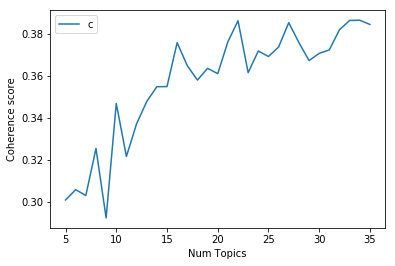

In [16]:
# Show graph
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
# Print the coherence scores
idx = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6), '  Model index', idx)
    idx += 1

Num Topics = 5  has Coherence Value of 0.300989   Model index 0
Num Topics = 6  has Coherence Value of 0.305879   Model index 1
Num Topics = 7  has Coherence Value of 0.303109   Model index 2
Num Topics = 8  has Coherence Value of 0.325485   Model index 3
Num Topics = 9  has Coherence Value of 0.292443   Model index 4
Num Topics = 10  has Coherence Value of 0.346892   Model index 5
Num Topics = 11  has Coherence Value of 0.321708   Model index 6
Num Topics = 12  has Coherence Value of 0.337194   Model index 7
Num Topics = 13  has Coherence Value of 0.347794   Model index 8
Num Topics = 14  has Coherence Value of 0.354879   Model index 9
Num Topics = 15  has Coherence Value of 0.354933   Model index 10
Num Topics = 16  has Coherence Value of 0.37583   Model index 11
Num Topics = 17  has Coherence Value of 0.364904   Model index 12
Num Topics = 18  has Coherence Value of 0.358026   Model index 13
Num Topics = 19  has Coherence Value of 0.363636   Model index 14
Num Topics = 20  has Coher

In [18]:
# Select the model and print the topics
index = 15
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)

In [19]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [20]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percent_contribution', 'keywords', 'text']

In [21]:
bonus_words = [text.split(', ') for text in df_dominant_topic['keywords'].tolist()]

In [22]:
len(bonus_words)

192

In [23]:
def summarize(text, sentence_count, bonus_words, language='english'):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)
    summarizer.bonus_words = bonus_words
    summarizer.stigma_words = ['zdfgthdvndadv']
    summarizer.null_words = stopwords.words('english')
    summary = summarizer(PlaintextParser(text, Tokenizer(language)).document, sentence_count)
    return summary

In [24]:
def print_summary(summary):
    for sentence in summary:
        print(sentence)

In [25]:
doc = 0
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('{} - {}'.format(chapter, hp[book][chapter][0]))
        words = bonus_words[doc]
        # split up bigrams used in LDA model
        words = [item for sublist in [item.split('_') for item in words] for item in sublist]
        words.extend(hp[book][chapter][0].lower().split())
        print_summary(summarize(hp[book][chapter][1], 5, words))
        doc += 1
        print()
    print()

Harry Potter and the Sorcerer's Stone
Chapter 1 - THE BOY WHO LIVED
At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs. Dursley on the cheek, and tried to kiss Dudley good-bye but missed, because Dudley was now having a tantrum and throwing his cereal at the walls.
When Dudley had been put to bed, he went into the living room in time to catch the last report on the evening news: "And finally, bird-watchers everywhere have reported that the nation's owls have been behaving very unusually today.
Twelve times he clicked the Put-Outer, until the only lights left on the whole street were two tiny pinpricks in the distance, which were the eyes of the cat watching him.
One small hand closed on the letter beside him and he slept on, not knowing he was special, not knowing he was famous, not knowing he would be woken in a few hours' time by Mrs. Dursley's scream as she opened the front door to put out the milk bottles, nor that he would spend the next few weeks being prodded an

At three-thirty that afternoon, Harry, Ron, and the other Gryffindors hurried down the front steps onto the grounds for their first flying lesson.
Harry saw his scared white face look down at the ground falling away, saw him gasp, slip sideways off the broom and — WHAM — a thud and a nasty crack and Neville lay facedown on the grass in a heap.
Malfoy only just got out of the way in time; Harry made a sharp about-face and held the broom steady.
He leaned forward and pointed his broom handle down — next second he was gathering speed in a steep dive, racing the ball — wind whistled in his ears, mingled with the screams of people watching — he stretched out his hand — a foot from the ground he caught it, just in time to pull his broom straight, and he toppled gently onto the grass with the Remembrall clutched safely in his fist.
Harry yelled, and the four of them sprinted down the gallery, not looking back to see whether Filch was following — they swung around the doorpost and galloped dow

Aunt Petunia's high, false laugh sounded from the living room.
If the Dursleys hear anything, if they know you're here —" "Harry Potter asks if he can help Dobby .
But Dobby has come to protect Harry Potter, to warn him, even if he does have to shut his ears in the oven door later.
There were screams from the dining room and Uncle Vernon  burst into the kitchen to find Harry, rigid with shock, covered from head to foot in Aunt Petunia's pudding.
Aunt Petunia was just passing around a box of after-dinner mints when a huge barn owl swooped through the dining room window, dropped a letter on Mrs. Mason's head, and swooped out again.

Chapter 3 - THE BURROW
"If the Dursleys wake up, I'm dead," said Harry as he tied the rope tightly around a bar and Fred revved up the car.
The car revved louder and louder and suddenly, with a crunching noise, the bars were pulled clean out of the window as Fred drove straight up in the air.
"One good push —" Harry and George threw their shoulders against th

The news that Colin Creevey had been attacked and was now lying as though dead in the hospital wing had spread through the entire school by Monday morning.
In the second week of December Professor McGonagall came around as usual, collecting names of those who would be staying at school for Christmas.
They still needed the bicorn horn and the boomslang skin, and the only place they were going to get them was from Snape's private stores.
As half the class lumbered up to Snape's desk, some weighted down with arms like clubs, others unable to talk through gigantic puffed-up lips, Harry saw Hermione slide back into the dungeon, the front of her robes bulging.
By next morning, however, the snow that had begun in the night had turned into a blizzard so thick that the last Herbology lesson of the term was canceled: Professor Sprout wanted to fit socks and scarves on the Mandrakes, a tricky operation she would entrust to no one else, now that it was so important for the Mandrakes to grow quickl

Far from wishing Harry a happy birthday, none of the Dursleys made any sign that they had noticed Harry enter the room, but Harry was far too used to this to care.
Even though she was not a blood relative of Harry's (whose mother had been Aunt Petunia's sister), he had been forced to call her "Aunt" all his life.
At Dudley's fifth birthday party, Aunt Marge had whacked Harry around the shins with her walking stick to stop him from beating Dudley at musical statues.
Harry knew perfectly well that Dudley only put up with Aunt Marge's hugs because he was well paid for it, and sure enough, when they broke apart, Dudley had a crisp twenty-pound note clutched in his fat fist.
Aunt Marge and Aunt Petunia kissed, or rather, Aunt Marge bumped her large jaw against Aunt Petunia's bony cheekbone.

Chapter 3 - THE KNIGHT BUS
His wand flew out of his hand as he flung out an arm to break his fall, and he landed, hard, in the gutter — There was a deafening BANG, and Harry threw up his hands to shield

I chose a very inconvenient time to fall ill." What with the promise of anti-dementor lessons from Lupin, the thought that he might never have to hear his mother's death again, and the fact that Ravenclaw flattened Hufflepuff in their Quid-ditch match at the end of November, Harry's mood took a definite upturn.
Resigned to the fact that he would be the only third year staying behind again, Harry borrowed a copy of Which Broomstick from Wood, and decided to spend the day reading up on the different makes.
They joined each other, they crisscrossed, they fanned into every corner of the parchment; then words began to blossom across the top, great, curly green words, that proclaimed: Messrs. Moony, Wormtail, Padfoot, and Prongs Purveyors of Aids to Magical Mischief-Makers are proud to present It was a map showing every detail of the Hogwarts castle and grounds.
Harry and Hermione made their way to the back of the room, where there was a small, vacant table between the window and a handsome 

"I found this at the base of the Whomping Willow," said Snape, throwing the cloak aside, careful to keep this wand pointing directly at Lupin's chest.
"I've told the headmaster again and again that you're helping your old friend Black into the castle, Lupin, and here's the proof.
Thin, snakelike cords burst from the end of Snape's wand and twisted themselves around Lupin's mouth, wrists, and ankles; he overbalanced and fell to the floor, unable to move.
With a roar of rage, Black started toward Snape, but Snape pointed his wand straight between Black's eyes.
Perhaps the dementors will have a kiss for him too —" Before he knew what he was doing, Harry had crossed the room in three strides and blocked the door.

Chapter 20 - THE DEMENTOR'S KISS
Harry went right after Black, who was still making Snape drift along ahead of them; he kept bumping his lolling head on the low ceiling.
Harry had the impression Black was making no effort to prevent this.
Black turned right around to look at him;

The tiny kitchen exploded with laughter; Harry looked around and saw that Ron and George were sitting at the scrubbed wooden table with two red-haired people Harry had never seen before, though he knew immediately who they must be: Bill and Charlie, the two eldest Weasley brothers.
Harry knew that he worked for the wizarding bank, Gringotts, and that Bill had been Head Boy at Hogwarts; Harry had always imagined Bill to be an older version of Percy: fussy about rule-breaking and fond of bossing everyone around.
Harry could tell that, however angry he was with Fred and George, he hadn't really intended to tell Mrs. Weasley what had happened.
Both of them smiled at Harry, who grinned back, which made Ginny go scarlet — she had been very taken with Harry ever since his first visit to the Burrow.
"If it's got anything to do with Weasleys' Wizard Wheezes —" "Why don't you show Harry where he's sleeping, Ron?"

Chapter 6 - THE PORTKEY
Mrs. Weasley was stirring the contents of a large pot on t

Professor Trelawney kept predicting Harry's death, which he found extremely annoying.
His preoccupation lasted all the way across the sodden vegetable patch until they arrived in greenhouse three, but here he was distracted by Professor Sprout showing the class the ugliest plants Harry had ever seen.
When the bell rang to signal the start of afternoon lessons, Harry and Ron set off for North Tower where, at the top of a tightly spiraling staircase, a silver stepladder led to a circular trapdoor in the ceiling, and the room where Professor Trelawney lived.
"Good day," said the misty voice of Professor Trelawney right behind Harry, making him jump.
It seems as though the Ministry of Magic's troubles are not yet at an end, writes Rita Skeeter, Special Correspondent.

Chapter 14 - THE UNFORGIVABLE CURSES
Harry knew these details because he had heard his parents' voices when he had fought the dementors last year — for that was the terrible power of the dementors: to force their victims to r

Lee passed Harry the egg, and Harry dug his fingernails into the groove that ran all the way around it and prised it open.
Drafty though the castle always was in winter, Harry was glad of its fires and thick walls every time he passed the Durmstrang ship on the lake, which was pitching in the high winds, its black sails billowingCHAPTER TWENTY-ONE against the dark skies.
Ron hovered behind the bookshelves for a while, watching Krum, debating in whispers with Harry whether he should ask for an autograph — but then Ron realized that six or seven girls were lurking in the next row of books, debating exactly the same thing, and he lost his enthusiasm for the idea.
She turned left at the bottom of the staircase and hurried toward the door through which Cedric Diggory had gone the night after the Goblet of Fire had regurgitated his and Harry's names.
He had one brief glimpse of an enormous, high-ceilinged room, large as the Great Hall above it, with mounds of glittering brass pots and pans h

"Harry Potter is brave and noble and Harry Potter is not nosy!
When they had set off into the dusk, looking extremely odd carrying the large package between them, Harry leaned on the windowsill, looking out at the grounds, at the dark, rustling treetops of the Forbidden Forest, and the rippling sails ofCHAPTER TWENTY-EIGHT the Durmstrang ship.
The bell rang across the grounds for lunch; the rest of the class set off back to the castle, but Harry, Ron, and Hermione stayed behind to help Hagrid put the nifflers back in their boxes.
The start of the summer term would normally have meant that Harry was training hard for the last Quidditch match of the season.
The Wronski Feint, you really —" But something moved behind Krum in the trees, and Harry, who had some experience of the sort of thing that lurked in the forest, instinctively grabbed Krum's arm and pulled him around.

Chapter 29 - THE DREAM
"He was sanest when he was trying to talk about Voldemort," said Harry, and Ron winced at the 

As he spoke, visions of everything that had passed that night seemed to rise before his eyes; he saw the sparkling surface of the potion that had revived Voldemort; he saw the Death Eaters Apparating between the graves around them; he saw Cedric's body, lying on the ground beside the cup.
Harry described how the figures that had emerged from the wand had prowled the edges of the golden web, how Voldemort had seemed to fear them, how the shadow of Harry's father had told him what to do, how Cedric's had made its final request.
He transformed back into the great black dog and walked with Harry and Dumbledore out of the office, accompanying them down a flight of stairs to the hospital wing.
Everything around him became hazy; the lamps around the hospital wing seemed to be winking at him in a friendly way through the screen around his bed; his body felt as though it was sinking deeper into the warmth of the feather matress.
"If the magical community got wind that I had approached the giant

Glittering jets of water were flying from the ends of the two wands, the point of the centaur's arrow, the tip of the goblin's hat, and each of the house-elf's ears, so that the tinkling hiss of falling water was added to the pops and cracks of Apparators and the clatter of footsteps as hundreds of witches and wizards, most of whom were wearing glum, early-morning looks, strode toward a set of golden gates at the far end of the hall.
The lift doors opened; Harry glimpsed an untidy-looking corridor, with various posters of Quidditch teams tacked lopsidedly on the walls; one of the wizards in the lift, who was carrying an armful of broomsticks, extricated himself with difficulty and disappeared down the corridor.
The doors closed, the lift juddered upward again, and the woman's voice said, "Level six, Department of Magical Transport, incorporating the Floo Network Authority, Broom Regulatory Control, Portkey Office, and Apparation Test Center."
"Level five, Department of International Ma

Professor Flitwick and Professor McGonagall both spent the first fifteen minutes of their lessons lecturing the class on the importance of O.W.L.s.
Professor Grubbly-Plank stood waiting for the class some ten yards from Hagrid's front door, a long trestle table in front of her laden with many twigs.
He had to give up his lunch hour to complete the picture of the bowtruckle, and meanwhile, Professors McGonagall, Grubbly-Plank, and Sinistra gave them yet more homework, which he had no prospect of finishing that evening because of his second detention with Umbridge.
Though Harry glanced toward the staff table automatically when he entered the Great Hall, it was without real hope of seeing Hagrid and he turned his mind immediately to his more pressing problems, such as the mountainous pile of homework he had to do and the prospect of yet another detention with Umbridge.
One was the thought that it was almost the weekend; the other was that, dreadful though his final detention with Umbridge

Harry sprinted up to the boys' dormitory to fetch the Invisibility Cloak and the Marauder's Map from his trunk; he was so quick that he and Ron were ready to leave at least five minutes before Hermione hurried back down from the girls' dormitories, wearing scarf, gloves, and one of her own knobbly elf hats.
"Well, they're not that difficult ter find, ter be honest," said Hagrid.
"Tell us about being attacked by the giants and Harry can tell you about being attacked by the dementors —" Hagrid choked in his mug and dropped his steak at the same time; a large quantity of spit, tea, and dragon blood was sprayed over the table as Hagrid coughed and spluttered and the steak slid, with a soft splat, onto the floor.
Partly 'cause they don' like wizards an' we didn' want ter put their backs up too soon, and partly 'cause Dumbledore had warned us You-Know-Who was bound ter be after the giants an' all.
Now you lot had better get back up to the castle, an' don' forget ter wipe yer footprints out b

It was breakfast time a few days after the sacking of Professor Trelawney, and Parvati was curling her eyelashes around her wand and examining the effect in the back of her spoon.
They did indeed burn sage and mallowsweet there on the classroom floor, and Firenze told them to look for certain shapes and symbols in the pungent fumes, but he seemed perfectly unconcerned that not one of them could see any of the signs he described, telling them that humansCHAPTER TWENTY-SEVEN were hardly ever good at this, that it took centaurs years and years to become competent, and finished by telling them that it was foolish to put too much faith in such things anyway, because even centaurs sometimes read them wrongly.
They all pelted toward the exit at once, forming a scrum at the door, then people burst through; Harry could hear them sprinting along the corridors and hoped they had the sense not to try and make it all the way to their dormitories.
Fudge looked incredulously from Harry to Professor U

The door through which they had come was ajar straight ahead, Harry could see the glittering light of the bell jar, he pelted through it, the prophecy still clutched tight and safe in his hand, waited for the others to hurtle over the threshold before slamming the door behind them — "Colloportus!"
Both Harry's and the Death Eater's wands flew out of their hands and soared back toward the entrance to the Hall of Prophecy; both scrambled to their feet and charged after them, the Death Eater in front and Harry hot on his heels, Neville bringing up the rear, plainly horrorstruck at what he had done.
Harry expected to hear a clunk, for the man to hit solid glass and slide off the jar onto the floor, but instead, his head sank through the surface of the bell jar as though it was nothing but a soap bubble and he came to rest, sprawled on his back on the table, with his head lying inside the jar full of glittering wind.
Neville was thrown over the desk and disappeared from view,CHAPTER THIRTY-

Harry and Dumbledore approached the back door of the Burrow, which was surrounded by the familiar litter of old Wellington boots and rusty cauldrons; Harry could hear the soft clucking of sleepy chickens coming from a distant shed.
Harry recognized it at once: It had nine hands, each inscribed with the name of a family member, and usually hung on the Weasleys' sitting room wall, though its current position suggested that Mrs. Weasley had taken to carrying it around the house with her.
They shook hands, and Mr. Weasley dropped into the chair beside Harry as Mrs. Weasley set a bowl of soup in front of him too.
Though a large vase of flowers had been placed on a desk in front of the small window, their perfume could not disguise the lingering smell of what Harry thought was gunpowder.
Ordinary Wizarding Level Results Pass Grades  Fail Grades Outstanding (O)  Poor (P) Exceeds Expectations (E)  Dreadful (D) Acceptable (A)  Troll (T) Harry James Potter has achieved: Astronomy A Care of Magic

The more Harry pored over the book, the more he realized how much was in there, not only the handy hints and shortcuts on potions that were earning him such a glowing reputation with Slughorn, but also the imaginative little jinxes and hexes scribbled in the margins, which Harry was sure, judging by the crossings-out and revisions, that the Prince had invented himself.
By the time they had got dressed, padding themselves out with several of Mrs. Weasley's hand-knitted sweaters and carrying cloaks, scarves, and gloves, Ron's shock had subsided and he had decided that Harry's new spell was highly amusing; so amusing, in fact, that he lost no time in regaling Hermione with the story as they sat down for breakfast.
More than once Harry wondered whether they might not have had a better time in the warm common room, and when they finally reached Hogsmeade and saw that Zonko's Joke Shop had been boarded up, Harry took it as confirmation that this trip was not destined to be fun.
It was a litt

Harry retold the story he had already recounted, it felt like a hundred times to Dumbledore, to McGonagall, to Madam Pomfrey, to Hermione, and to Ginny.
Having hurtled, white-faced, up to Harry outside the hospital wing and demanded to know what had happened, she had taken almost no part in Harry and Ginny's obsessive discussion about how Ron had been poisoned, but merely stood beside them, clench-jawed and frightened-looking, until at last they had been allowed in to see him.
It might even be that Dumbledore did not want anything to distract Harry from their lessons, or from procuring that memory from Slughorn.
McLaggen kept up a constant stream of hints that he would make a better permanent Keeper for the team than Ron, and that now that Harry was seeing him play regularly he would surely come around to this way of thinking too; he was also keen to criticize the other players and provide Harry with detailed training schemes, so that more than once Harry was forced to remind him who w

And with the sudden agility of a much younger man, Dumbledore slid from the boulder, landed in the sea, and began to swim, with a perfect breaststroke, toward the dark slit in the rock face, his lit wand held in his teeth.
The greenish glow and the light from the two wands were the only things that broke the otherwise velvety blackness, though their rays did not penetrate as far as Harry would have expected.
The surface of the lake was no longer mirror-smooth; it was churning, and everywhere Harry looked, white heads and hands were emerging from the dark water, men and women and children with sunken, sightless eyes were moving toward the rock: an army of the dead rising from the black water.
yelled Harry, struggling to cling to the smooth, soaked surface of the island as he pointed his wand at the Inferius that had his arm: It released him, falling backward into the water with a splash; he scrambled to his feet, but many more Inferi were already climbing onto the rock, their bony hands

Harry saw the Death Eaters swerve out of sight to avoid the deadly trail of flame, and at the same time felt the sidecar sway ominously: Its metal connections to the bike had splintered with the force of acceleration.
There was a deafening bang and the sidecar broke away from the bike completely: Harry sped forward, propelled by the impetus of the bike's flight, then the sidecar began to lose height — In desperation Harry pointed his wand at the sidecar and shouted, "Wingardium Leviosa!"
The jinx hit the middle Death Eater in the chest: For a moment the man was absurdly spread-eagled in midair as though he had hit an invisible barrier: One of his fellows almost collided with him — Then the sidecar began to fall in earnest, and the remaining Death Eater shot a curse so close to Harry that he had to duck below the rim of the car, knocking out a tooth on the edge of his seat — "I'm comin', Harry, I'm comin'!"
He shot another blocking jinx at them: The closest Death Eater swerved to avoid 

The usual low whisper of "Severus Snape?"
"&lsquo;Severus Snape, long-standing Potions master at Hogwarts School of Witchcraft and Wizardry, was today appointed headmaster in the most important of several staffing changes at the ancient school.
The painted image of Phineas Nigellus Black was able to flit between his portrait in Grimmauld Place and the one that hung in the headmaster's office at Hogwarts: the circular tower-top room where Snape was no doubt sitting right now, in triumphant possession of Dumbledore's collection of delicate, silver magical instruments, the stone Pensieve, the Sorting Hat and, unless it had been moved elsewhere, the sword of Gryffindor.
A disembodied female voice said, "Level four, Department for the Regulation and Control of Magical Creatures, incorporating Beast, Being, and Spirit Divisions, Goblin Liaison Office, and Pest Advisory Bureau," and the grilles slid open again, admitting a couple of wizards and several pale violet paper airplanes that flutter

Finally he got up in the darkness and joined Hermione, who was huddled in the entrance to the tent reading A History of Magic by the light of her wand.
The imprint of the doe faded away with every blink of his eyes as he stood there, listening to the sounds of the forest, to distant crackles of twigs, soft swishes of snow.
Something gleamed in the light of the wand, and Harry spun about, but all that was there was a small, frozen pool, its cracked black surface glittering as he raised the wand higher to examine it.
Ron raised the sword in his shaking hands: The point dangled over the frantically swiveling eyes, and Harry gripped the locket tightly, bracing himself, already imagining blood pouring from the empty windows.
They explained what had happened, and as the story of the silver doe and the sword in the pool unfolded, Hermione frowned from one to the other of them, concentrating so hard she forgot to keep her limbs locked together.

Chapter 20 - XENOPHILIUS LOVEGOOD
"I want to go 

He saw the achingly familiar Hogsmeade High Street: dark shop fronts, and the outline of black mountains beyond the village, and the curve in the road ahead that led off toward Hogwarts, and light spilling from the windows of the Three Broomsticks, and with a lurch of the heart he remembered, with piercing accuracy, how he had landed here nearly a year before, supporting a desperately weak Dumbledore; all this in a second, upon landing — and then, even as he relaxed his grip upon Ron's and Hermione's arms, it happened.
Even as he looked at the other two beneath the Cloak, the door of the Three Broomsticks burst open and a dozen cloaked and hooded Death Eaters dashed into the street, their wands aloft.
Six of the Death Eaters ran toward them: Harry, Ron, and Hermione backed as quickly as possible down the nearest side street, and the Death Eaters missed them by inches.
They waited in the darkness, listening to the footsteps running up and down, beams of light flying along the street fro

Stunned, Harry followed as Dumbledore strode away from where the flayed child lay whimpering, leading him to two seats that Harry had not previously noticed, set some distance away under that high, sparkling ceiling.
Happiness seemed to radiate from Dumbledore like light, like fire: Harry had never seen the man so utterly, so palpably content.
"But if Voldemort used the Killing Curse," Harry started again, "and nobody died for me this time — how can I be alive?"
For the first time since Harry had met Dumbledore, he looked less than an old man, much less.
Dumbledore patted Harry's hand, and Harry looked up at the old man and smiled; he could not help himself.


